In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline

#### Helper Functions

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
# For selecting columns
def likert_cols(col_list, q_code):
    holder = [i for i in col_list if i [:4]==q_code]
    cols = [i for i in holder if len(i[5:])<=2]
    
    return cols[:-1]

In [4]:
# For recoding Likert answers to numbers
def recode(df,keyword):
    new_df = df.copy()
    cols = new_df.columns

    if keyword == "v":
        for i in cols:
            new_df[i] = new_df[i].map({"Not very valuable":1,"Slightly valuable":2,"Moderately valuable":3,
                                       "Quite valuable":4,"Extremely valuable":5})
    elif keyword == "a":
        for i in cols:
            new_df[i] = new_df[i].map({"Not at all accurate":1,"Slightly accurate":2,"Moderately accurate":3,
                                       "Quite accurate":4,"Extremely accurate":5})
    elif keyword == "f":
        for i in cols:
            new_df[i] = new_df[i].map({"Not at all familiar":1,"Slightly familiar":2,"Moderately familiar":3,
                                       "Quite familiar":4,"Extremely familiar":5})
    return new_df

In [5]:
#Impute and recreate the dataframe
def impute_to_df(df,strat):
    cols = list(df.columns)
    imp = Imputer(strategy=strat)
    
    imputed = imp.fit_transform(df)
    new_df = pd.DataFrame(imputed, columns = cols)
    
    return new_df 

In [6]:
# Determine group membership
# EXAMINE if this is the best way ("biggest number is your group")
# ADJUST so that it reflects NOT having the "Program" column (wont need for future)
def make_groups(df):
    clusters = len([i for i in list(df.columns) if i[0:2] == "pc"])
#     pcs = [i for i in list(df.columns) if i[0:2] == "pc"]
    k = KMeans(n_clusters = clusters)
    groups = k.fit_predict(df.iloc[:,1:])
    return groups

In [7]:
# displays graph of explained variance ratio
# so you can use elbow method to choose number of components
def choose_comp(df, n = 5, impute=True):
    if impute == True:
        df = impute_to_df(df,"median")
    
    pca = PCA(n_components = n)
    pca.fit(df)
    
    ev = pca.explained_variance_ratio_
    cv = []
    for i, j in enumerate(ev):
        if i == 0:
            cv.append(j)
        else:
            cv.append(cv[i-1]+j)
    
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(range(1,n+1),ev, "o-")
    ax[0].set_title("Explained Variance Ratio")
    ax[0].set_xlabel("n_components")
    
    ax[1].plot(range(1,n+1),cv, "o-")
    ax[1].set_title("Cumulative Explained Variance")
    ax[1].set_xlabel("n_components")
    print(cv)
    return
    

In [8]:
# imputes, does pca, returns a dataframe with pca loads
# returns another with the pca scores and group membership
def do_pca(df, n_comp, groupname, txt = None, impute=True):
    if impute==True:
        df = impute_to_df(df,"median")  
    
    pca = PCA(n_components = n_comp)
    df_pca = pca.fit_transform(df)
    
    
    cols = ["PC-%i"%(i+1) for i in range(n_comp)]

    df_loads = pd.DataFrame(pca.components_,columns=list(df.columns),index = [cols]).T
    if txt is not None:
        df_loads = df_loads.join(txt)

    pca_frame = pd.DataFrame({"Program":finishers.Program.loc[df.index]})
    for i in range(pca.explained_variance_ratio_.shape[0]):
        pca_frame["pc%i" % (i+1)] = df_pca[:,i]  
    pca_frame[groupname] = make_groups(pca_frame)
    return df_loads, pca_frame

In [9]:
# plots pca1 vs pca2
def plot_pca(df, title):
    plt.plot(df.pc1[df.Group == 0],
         df.pc2[df.Group == 0],"o", color = "green")
    plt.plot(df.pc1[df.Group == 1],
         df.pc2[df.Group == 1],"o", color = "blue")
    plt.xlabel("PC-1")
    plt.ylabel("PC-2")
    plt.title(title)

#### Do the stuff

In [10]:
data = pd.read_csv("master.csv")

In [11]:
# DROPS here. Don't re run unless you re run above cell first.
data1 = data.drop(data.index[1])
data1 = data1.iloc[:,16:]
data1.drop(['Q237_4','Q237_5'],axis=1,inplace=True)
data1 = data1.drop(data.index[0])

In [12]:
data1["Progress"] = data["Progress"]
data1 = data1.apply(pd.to_numeric, errors='ignore')
finishers = data1[data1.Progress>60]

In [13]:
text = pd.read_csv("HPL_QuestionText.csv",header=None,names=["code",'text'])
text.set_index('code',inplace=True)

In [14]:
all_cols = list(data1.columns)

In [15]:
# columns for likert dfs
likert1_cols = likert_cols(all_cols,"Q252")
likert2_cols = likert_cols(all_cols,"Q265")
likert3_cols = likert_cols(all_cols,"Q266")
likert4_cols = likert_cols(all_cols,"Q267")

# likert 5 is weird, it is Q279-Q372, but every 4th column, AND there are random
# out of order numbers (eg, goes 294,404,405,406,297)
ends = [all_cols.index("Q279"), all_cols.index("Q372")+1]
likert5_cols = [j for i, j in enumerate(all_cols[ends[0]:ends[1]]) if i % 4 == 0]

# back to the regular way
likert6_cols = likert_cols(all_cols,"Q382")
likert7_cols = likert_cols(all_cols,"Q384")

likert1_cols = [i for i in likert1_cols if i not in "Q252_16"]

In [16]:
# columns to DFs
likerts = {}
likerts["likert1"] = finishers[likert1_cols]
likerts["likert2"] = finishers[likert2_cols]
likerts["likert3"] = finishers[likert3_cols]
likerts["likert4"] = finishers[likert4_cols]
likerts["likert5"] = finishers[likert5_cols]
likerts["likert6"] = finishers[likert6_cols]
likerts["likert7"] = finishers[likert7_cols]

In [17]:
# Recode Likert Scales
recoded = {}
recoded["recode1"] = recode(likerts["likert1"],"v")
recoded["recode2"] = recode(likerts["likert2"],"a")
recoded["recode3"] = recode(likerts["likert3"],"a")
recoded["recode4"] = recode(likerts["likert4"],"a")
recoded["recode5"] = recode(likerts["likert5"],"a")
recoded["recode6"] = recode(likerts["likert6"],"f")
recoded["recode7"] = recode(likerts["likert7"],"f")

[0.37801888098076714, 0.5563053500240467, 0.644866683309475, 0.7220107704070691, 0.7907278139384243]
[0.23771203623700876, 0.4117296087089143, 0.5363798302867676, 0.6412659084525633, 0.7135815456135466]
[0.40207402431900413, 0.5862900332221072, 0.7270929393865084, 0.8290697129963083, 0.8836290163626868]
[0.35054524453835134, 0.537208182027878, 0.6835726593162632, 0.7951364773746101, 0.8776619961062679]
[0.16767821619035292, 0.2688672052988281, 0.365539981667046, 0.44836898947011794, 0.5255305860388877]
[0.46283864722605805, 0.555320908057932, 0.6315689827553922, 0.6888258762549776, 0.7308876817218378]
[0.5118814462328843, 0.5816330188782294, 0.64301462298778, 0.6940985714103146, 0.7446180406368994]


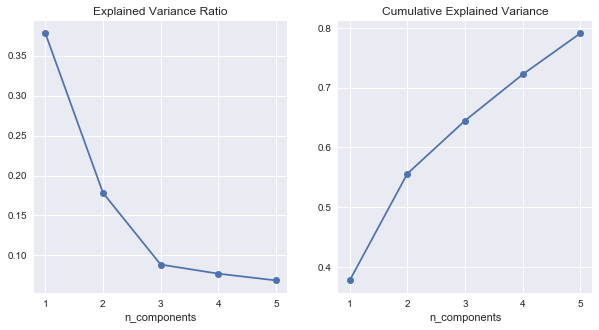

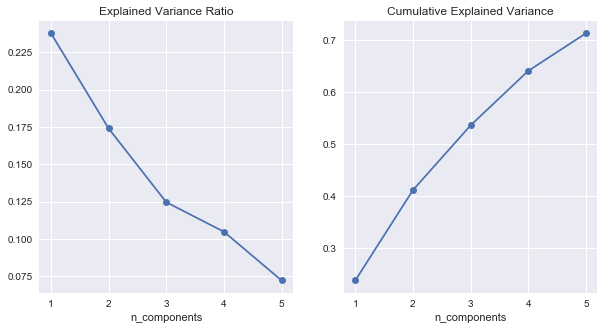

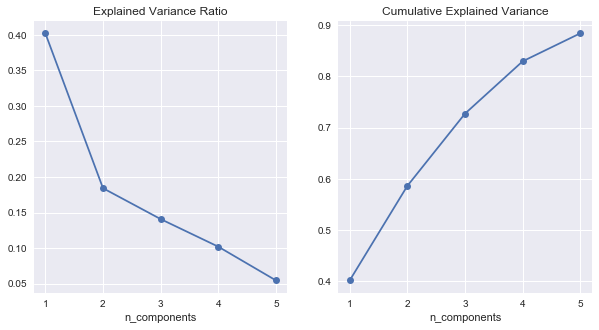

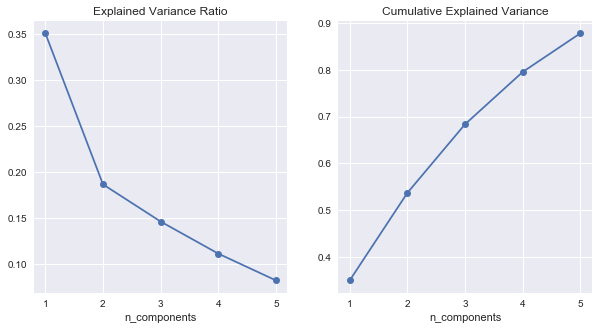

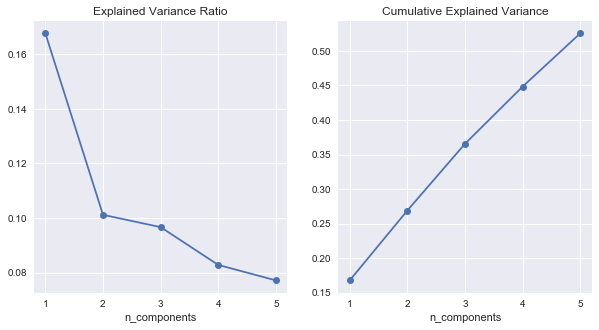

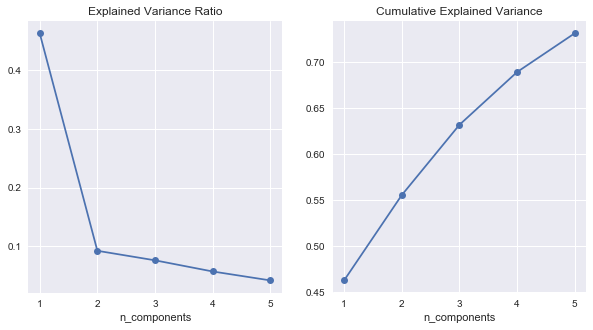

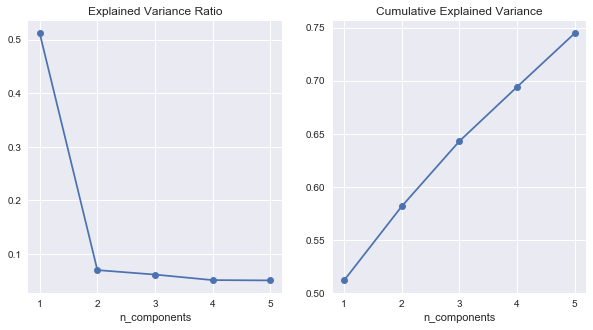

In [18]:
# Choose PCA components (which are a proxy for n_clusters)
for key in recoded.keys():
    choose_comp(recoded[key])

In [19]:
# n_components
comp = [2,2,2,2,2,2,2]

In [20]:
# do_pca
results = {}
for i in range(1,8):
    results["r{}_loads".format(i)], results["r{}pca_df".format(i)] = do_pca(recoded["recode{}".format(i)],comp[i-1],"Group".format(i), text)
    print(i)

1
2
3
4
5
6
7


In [21]:
results.keys()

dict_keys(['r1_loads', 'r1pca_df', 'r2_loads', 'r2pca_df', 'r3_loads', 'r3pca_df', 'r4_loads', 'r4pca_df', 'r5_loads', 'r5pca_df', 'r6_loads', 'r6pca_df', 'r7_loads', 'r7pca_df'])

### Likert 1

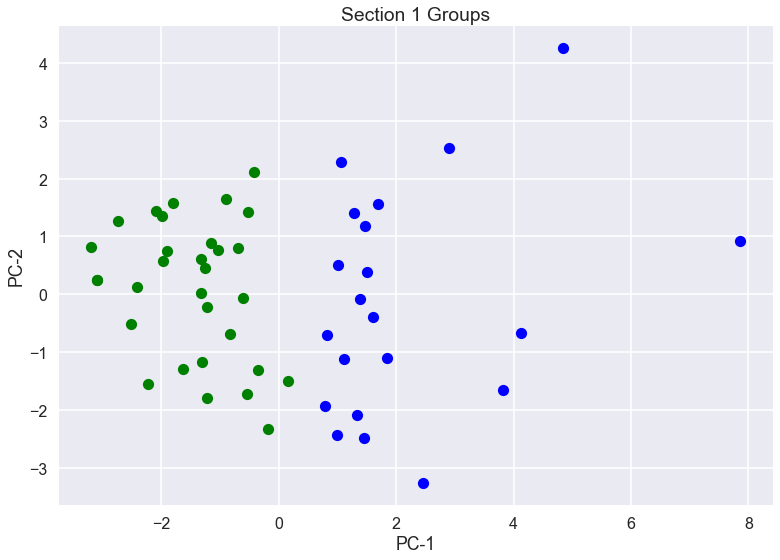

In [22]:
sns.set_context("poster")
# sns.pairplot(results["r1pca_df"],hue="Group")
# plt.suptitle("Likert Qs 1 (Valuable)",y=1.1,fontsize=18)
plot_pca(results["r1pca_df"],"Section 1 Groups")


In [23]:
display_side_by_side(results["r1_loads"][["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],

results["r1_loads"][["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q252_11,-0.097305,(V) How governmental policy shapes peopleâ€™s ...
Q252_10,-0.140101,(V) How to support people working in groups or...
Q252_14,-0.153179,(V) The role of motivation in learning
Q252_12,-0.228761,(V) How institutional policy and practice shap...
Q252_9,-0.306716,(V) How age or stage of development influences...
,PC-2,text
Q252_12,0.584234,(V) How institutional policy and practice shap...
Q252_11,0.568592,(V) How governmental policy shapes peopleâ€™s ...
Q252_10,0.196797,(V) How to support people working in groups or...
Q252_8,0.168145,(V) How to evaluate teaching or educational pr...


### Likert 2

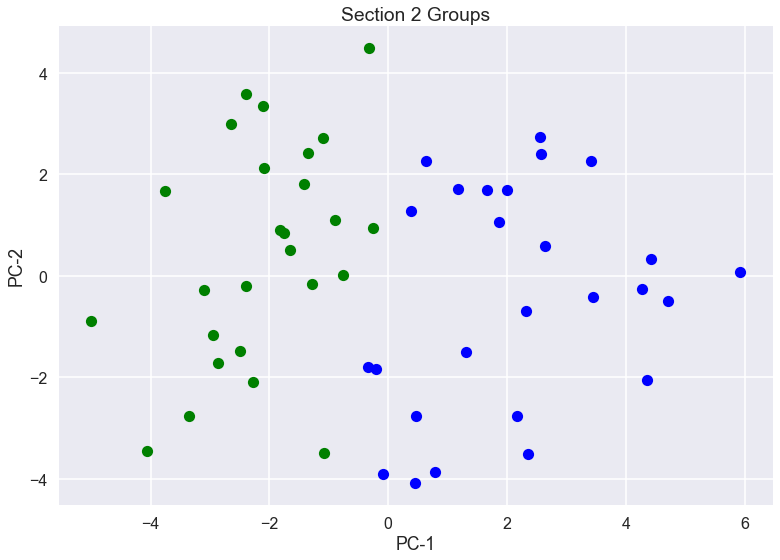

In [24]:
# sns.pairplot(results["r2pca_df"],hue="Group")
# plt.suptitle("Likert Qs 2 (Meaningful Ed Experience)",y=1.1,fontsize=18)
plot_pca(results["r2pca_df"],"Section 2 Groups")

In [25]:
display_side_by_side(results["r2_loads"][["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],

results["r2_loads"][["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q265_6,0.360340,(EE) It was extracurricular or informal.
Q265_13,0.213542,(EE) It involved one-on-one interaction with t...
Q265_9,0.062723,(EE) It was related to nonacademic things I wa...
Q265_17,-0.046947,(EE) I was able to choose how I participated i...
Q265_15,-0.156570,(EE) It involved solving real-world problems.
,PC-2,text
Q265_15,0.506457,(EE) It involved solving real-world problems.
Q265_6,0.388220,(EE) It was extracurricular or informal.
Q265_9,0.358774,(EE) It was related to nonacademic things I wa...
Q265_18,0.299224,(EE) It involved teamwork or a group project.


### Likert 3

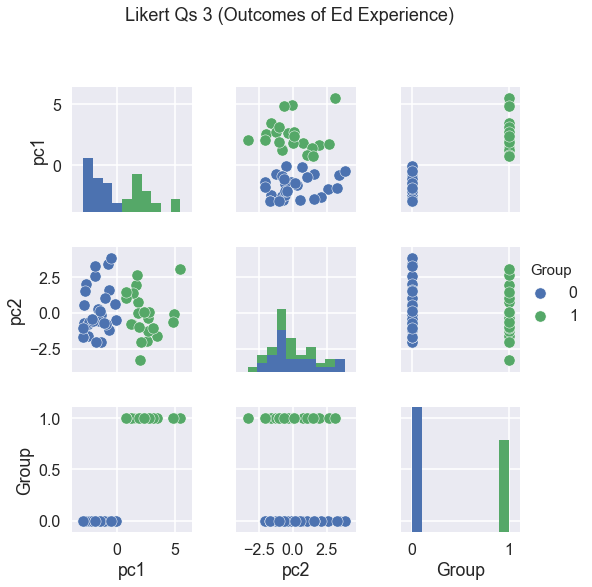

In [26]:
sns.pairplot(results["r3pca_df"],hue="Group")
plt.suptitle("Likert Qs 3 (Outcomes of Ed Experience)",y=1.1,fontsize=18)

In [27]:
display_side_by_side(results["r3_loads"][["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],

results["r3_loads"][["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q266_5,-0.001381,(EE) I gained a deeper understanding of concep...
Q266_11,-0.034230,(EE) I gained new skills.
Q266_4,-0.069190,(EE) I learned new concepts (including informa...
Q266_12,-0.153646,(EE) I had meaningful interactions with other ...
Q266_15,-0.375482,(EE) My aspirations for my future changed.
,PC-2,text
Q266_10,0.251836,(EE) My beliefs about a topic changed.
Q266_14,0.181703,(EE) My personal values about a topic changed.
Q266_13,-0.081061,(EE) My beliefs about myself changed.
Q266_12,-0.178031,(EE) I had meaningful interactions with other ...


### Likert 4

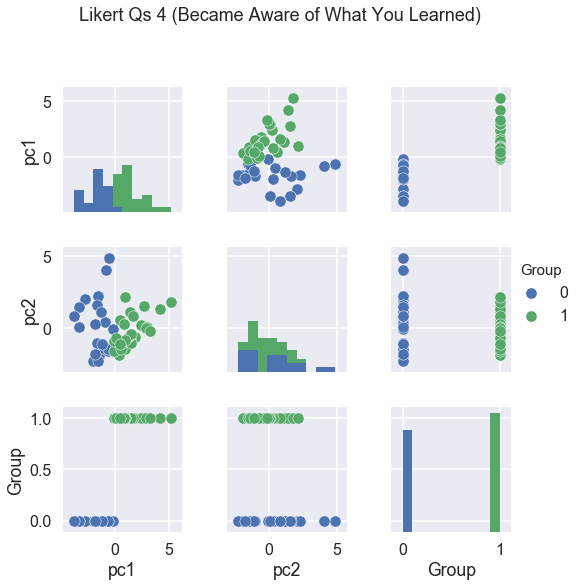

In [28]:
sns.pairplot(results["r4pca_df"],hue="Group")
plt.suptitle("Likert Qs 4 (Became Aware of What You Learned)",y=1.1,fontsize=18)

In [29]:
display_side_by_side(results["r4_loads"][["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],

results["r4_loads"][["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q267_10,-0.059011,(EE) I reflected on my learning some time afte...
Q267_11,-0.066530,(EE) I applied what I learned in a later situa...
Q267_12,-0.118743,(EE) I taught something I learned from that ex...
Q267_14,-0.316898,(EE) I became more interested in the subject o...
Q267_9,-0.419308,(EE) I was consciously aware that I was learni...
,PC-2,text
Q267_4,0.765013,"(EE) There was a test, assignment, or other as..."
Q267_5,0.015918,(EE) The teacher/leader gave me direct feedbac...
Q267_11,-0.086154,(EE) I applied what I learned in a later situa...
Q267_9,-0.123651,(EE) I was consciously aware that I was learni...


### Likert 5

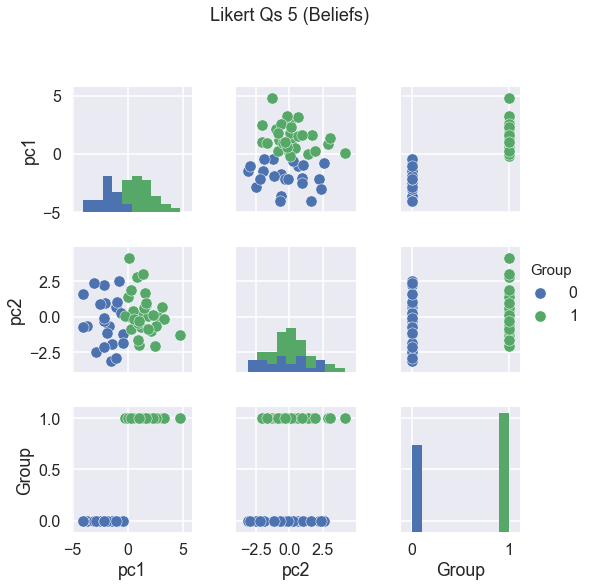

In [30]:
sns.pairplot(results["r5pca_df"],hue="Group")
plt.suptitle("Likert Qs 5 (Beliefs)",y=1.1,fontsize=18)

In [31]:
display_side_by_side(results["r5_loads"][["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],

results["r5_loads"][["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q349,0.483571,(B) Learning should be tightly connected to th...
Q316,0.315044,(B) Stress and anxiety can be beneficial if th...
Q312,0.292639,(B) A learner needs to master some basic facts...
Q296,0.254278,(B) Learners are ultimately responsible for th...
Q283,0.243507,"(B) Human biology (i.e., neuroscience, genetic..."
,PC-2,text
Q316,0.394578,(B) Stress and anxiety can be beneficial if th...
Q312,0.377494,(B) A learner needs to master some basic facts...
Q300,0.342401,"(B) If a person puts in the effort, they can l..."
Q296,0.144664,(B) Learners are ultimately responsible for th...


### Likert 6

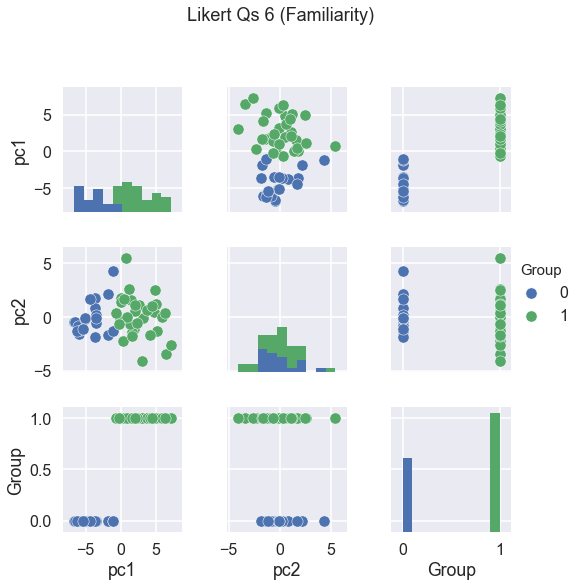

In [32]:
sns.pairplot(results["r6pca_df"],hue="Group")
plt.suptitle("Likert Qs 6 (Familiarity)",y=1.1,fontsize=18)

In [33]:
display_side_by_side(results["r6_loads"][["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],

results["r6_loads"][["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q382_8,0.284533,(F) Assessment of learning
Q382_19,0.280231,(F) Motivation in learning
Q382_11,0.265708,(F) Differentiation of instruction
Q382_18,0.249732,(F) Metacognition
Q382_14,0.245211,(F) Group learning
,PC-2,text
Q382_11,0.481673,(F) Differentiation of instruction
Q382_15,0.321081,(F) Learning differences and disabilities
Q382_22,0.271639,(F) Socioemotional learning (SEL)
Q382_8,0.211277,(F) Assessment of learning


### Likert 7 (combine with 6?)

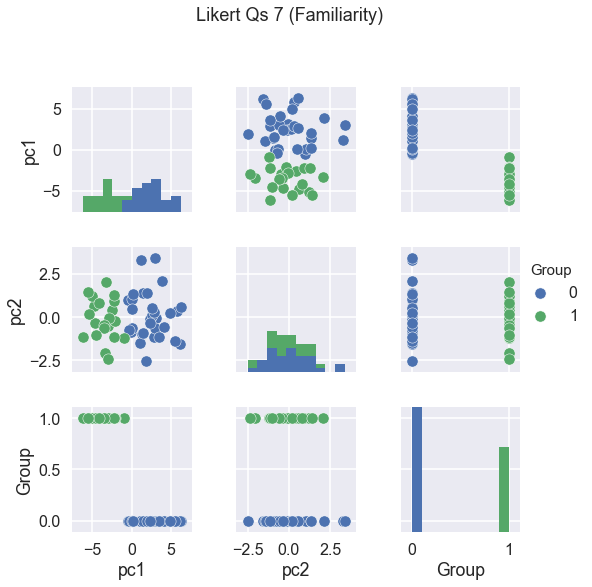

In [34]:
sns.pairplot(results["r7pca_df"],hue="Group")
plt.suptitle("Likert Qs 7 (Familiarity)",y=1.1,fontsize=18)

In [35]:
display_side_by_side(results["r7_loads"][["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],

results["r7_loads"][["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q384_28,-0.114411,(F) How the mind stores information or knowledge.
Q384_45,-0.189641,(F) The different ways people think through in...
Q384_41,-0.195391,(F) How individuals predictably progress throu...
Q384_27,-0.208319,(F) How learning can be enhanced or influenced...
Q384_36,-0.212908,(F) How testing affects learning.
,PC-2,text
Q384_31,0.572593,"(F) Differences among coaching, teaching, and ..."
Q384_43,0.358911,(F) How people work together to solve problems...
Q384_30,0.331498,(F) Differences between knowing and understand...
Q384_38,0.227314,(F) The process by which newcomers learn from ...


## cluster individuals based on all the groups that they are in(?):

In [36]:
combo_df = pd.DataFrame({"Program":finishers.Program})
combo_df["Group1"] = results["r1pca_df"].Group
combo_df["Group2"] = results["r2pca_df"].Group
combo_df["Group3"] = results["r3pca_df"].Group
combo_df["Group4"] = results["r4pca_df"].Group
combo_df["Group5"] = results["r5pca_df"].Group
combo_df["Group6"] = results["r6pca_df"].Group
combo_df["Group7"] = results["r7pca_df"].Group

In [37]:
test = combo_df.iloc[:,1:]

[0.2585343487749379, 0.46873894192011156, 0.6304924195302747, 0.7791775775436005, 0.8697957161275252]


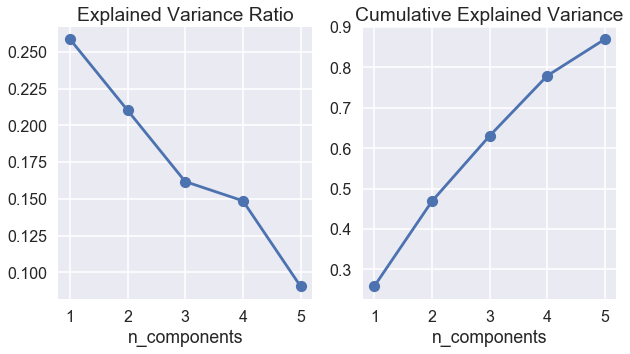

In [38]:
choose_comp(test)

In [39]:
t_loads, t_df = do_pca(test,4,"HyperGroup")

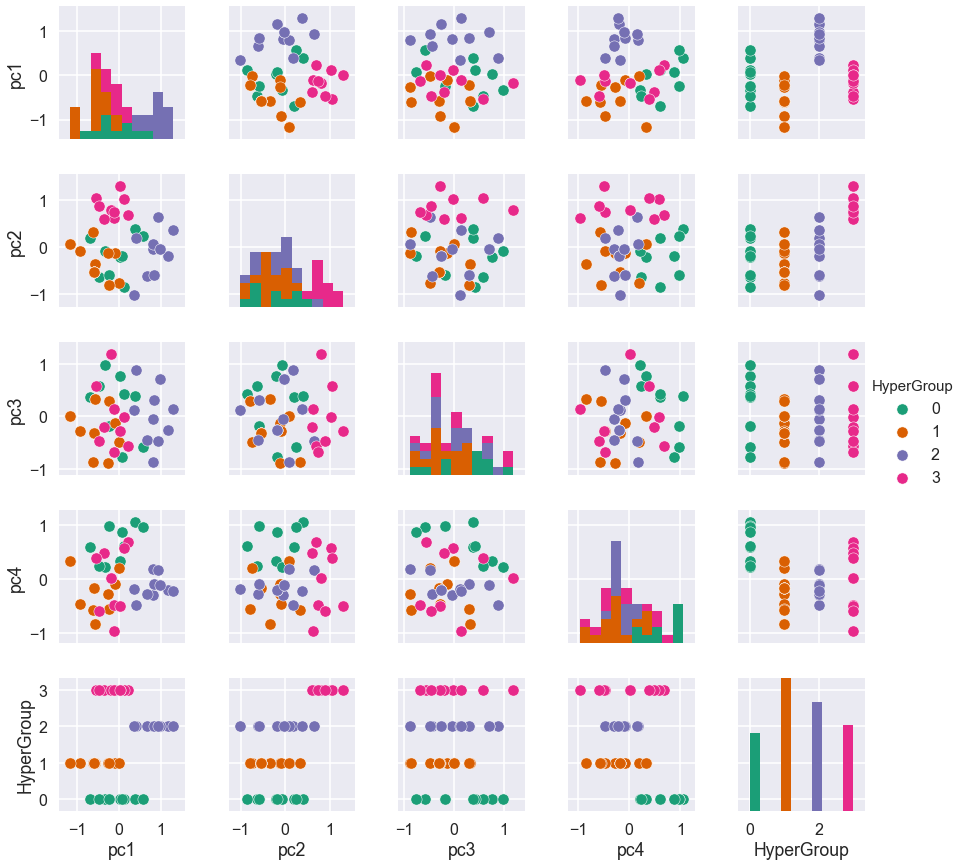

In [40]:
c = sns.color_palette("Paired")
sns.pairplot(t_df, hue="HyperGroup",palette="Dark2")

In [41]:
t_df.head(7)[2:]

,Program,pc1,pc2,pc3,pc4,HyperGroup
2,"Mind, Brain & Education",-0.184886,0.798641,1.187781,0.022361,3
3,"Mind, Brain & Education",1.159809,-0.179940,-0.266922,-0.196444,2
4,"Technology, Innovation & Educ",-0.687388,0.191780,0.377198,0.593340,0
5,Learning & Teaching,-0.230195,-0.790265,0.296602,-0.550275,1
6,"Technology, Innovation & Educ",-0.572382,-0.343714,0.322851,-0.836970,1


In [42]:
display_side_by_side(t_loads.sort_values(by="PC-1",ascending=False).iloc[0:3,0:1],
                     t_loads.sort_values(by="PC-2",ascending=False).iloc[0:3,1:2],
                     t_loads.sort_values(by="PC-3",ascending=False).iloc[0:3,2:3],
                     t_loads.sort_values(by="PC-4",ascending=False).iloc[0:3,3:4])

,PC-1
Group7,0.582594
Group6,0.342187
Group1,0.138323
,PC-2
Group1,0.558037
Group4,0.260146
Group3,0.163862
,PC-3
Group5,0.573433
Group1,0.399740


In [43]:
combo_df.head()

,Program,Group1,Group2,Group3,Group4,Group5,Group6,Group7
2,"Mind, Brain & Education",1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,"Mind, Brain & Education",0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,"Technology, Innovation & Educ",1.0,0.0,1.0,0.0,1.0,0.0,0.0
5,Learning & Teaching,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,"Technology, Innovation & Educ",1.0,1.0,1.0,1.0,1.0,1.0,0.0


Not *exactly* sure what to make of this. What do the groups mean? Does it matter? Next step: do this, but without the subgrouping (ie, pca/cluster using all questions). How will the group membership change?

## Cluster using all questions (rather than grouped)

In [44]:
big_df = pd.DataFrame({"Program":finishers.Program})
big_df = big_df.join(recoded["recode1"])
big_df = big_df.join(recoded["recode2"])
big_df = big_df.join(recoded["recode3"])
big_df = big_df.join(recoded["recode4"])
big_df = big_df.join(recoded["recode5"])
big_df = big_df.join(recoded["recode6"])
big_df = big_df.join(recoded["recode7"])
big_df.head()

,Program,Q252_4,Q252_5,Q252_6,Q252_7,Q252_8,Q252_9,Q252_10,Q252_11,Q252_12,...,Q384_36,Q384_37,Q384_38,Q384_39,Q384_40,Q384_41,Q384_42,Q384_43,Q384_44,Q384_45
2,"Mind, Brain & Education",5,5,3,5,5,5,4,3,3,...,2,2,1.0,4,3,3,2,2,3,2
3,"Mind, Brain & Education",5,2,4,2,3,4,5,4,5,...,3,3,2.0,3,3,3,4,3,3,2
4,"Technology, Innovation & Educ",3,3,5,4,3,3,4,2,2,...,4,4,1.0,4,4,2,4,3,3,3
5,Learning & Teaching,5,5,5,5,5,5,5,4,5,...,4,4,4.0,4,4,4,4,4,4,4
6,"Technology, Innovation & Educ",5,4,3,5,5,3,3,3,3,...,1,1,1.0,2,2,1,1,2,2,1


[0.19101796042547736, 0.26219450319265103, 0.3257499245492771, 0.3757830648025153, 0.42215050577604246]


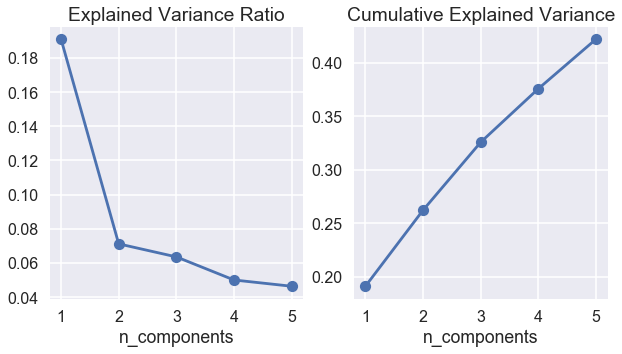

In [45]:
choose_comp(big_df.iloc[:,1:])

In [46]:
big_load, big_pca = do_pca(big_df.iloc[:,1:],2,"HyperGroup",text)

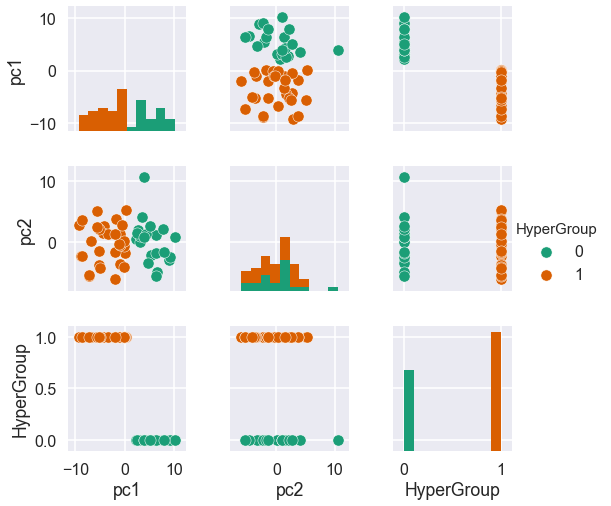

In [47]:
sns.pairplot(big_pca,hue="HyperGroup",palette="Dark2")

In [48]:
display_side_by_side(big_load[["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],
                     big_load[["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q382_8,0.201511,(F) Assessment of learning
Q382_19,0.197540,(F) Motivation in learning
Q382_11,0.193054,(F) Differentiation of instruction
Q382_14,0.185202,(F) Group learning
Q384_42,0.177943,(F) How attitudes and emotions affect learning.
,PC-2,text
Q265_6,0.243387,(EE) It was extracurricular or informal.
Q252_4,0.148513,(V) How to design learning experiences or curr...
Q252_13,0.130755,(V) The neuroscience of learning
Q382_25,0.124954,(F) Transfer of learning


There is some nice separation here. HOWEVER, the PCA components are kind of vague (on first glance, it sort of looks like "teachers vs. people interested learning about learning") What that might mean is we should take each of these clusters and further cluster them separately (ie, the reverse of all the stuff we just did).

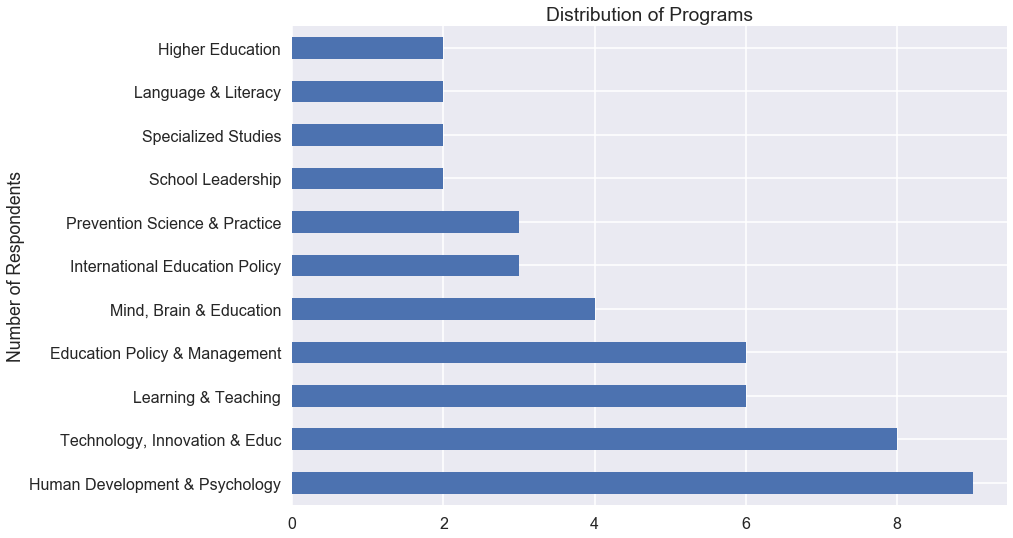

In [62]:
sns.set_context("poster")
big_pca["Program"].value_counts().plot(kind="barh")
plt.title("Distribution of Programs")
plt.ylabel("Number of Respondents")

## "Manual" Hierarchichal Clustering

### Hypergroup -> Level 1

HG 0: Teachers
HG 1: Non- teachers

How do each of these groups break down? (Also, when do we stop?)

In [50]:
# New dfs to do clustering on (I think I'm basically doing a manual version of hierarchical clustering)
group_0_ind = list(big_pca[big_pca.HyperGroup == 0].index)
group_1_ind = list(big_pca[big_pca.HyperGroup == 1].index)

group_0 = big_df.loc[group_0_ind].iloc[:,1:]
group_1 = big_df.loc[group_1_ind].iloc[:,1:]

[0.20975321995712, 0.3095616685882832, 0.3963552241231699, 0.46815576462178826, 0.5361383754979261]


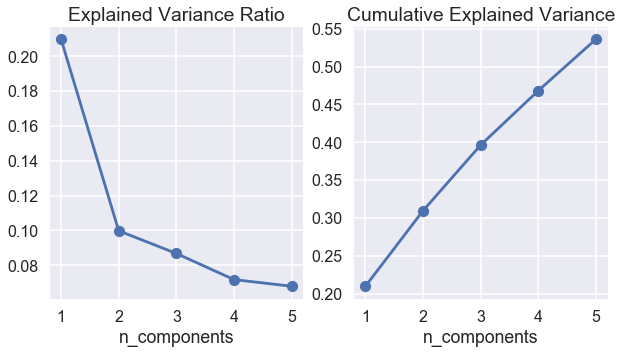

In [51]:
choose_comp(group_0)

[0.21587093180874406, 0.3273788668847857, 0.39974662545258455, 0.46363457215514486, 0.5230865532484205]


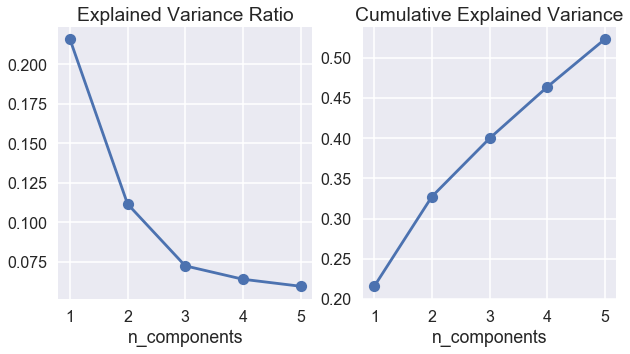

In [52]:
choose_comp(group_1)

In [53]:
g0_load, g0pca = do_pca(group_0,2,"Level1",text)

In [54]:
display_side_by_side(g0_load[["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],
                     g0_load[["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q382_19,0.193773,(F) Motivation in learning
Q384_35,0.180445,(F) What gets students motivated or driven to ...
Q384_29,0.179170,(F) Differences between the concepts of learni...
Q382_21,0.175359,(F) Situated learning
Q382_5,0.172730,(F) Expertnovice differences
,PC-2,text
Q266_10,0.304036,(EE) My beliefs about a topic changed.
Q266_15,0.261193,(EE) My aspirations for my future changed.
Q266_14,0.214528,(EE) My personal values about a topic changed.
Q265_6,0.214242,(EE) It was extracurricular or informal.


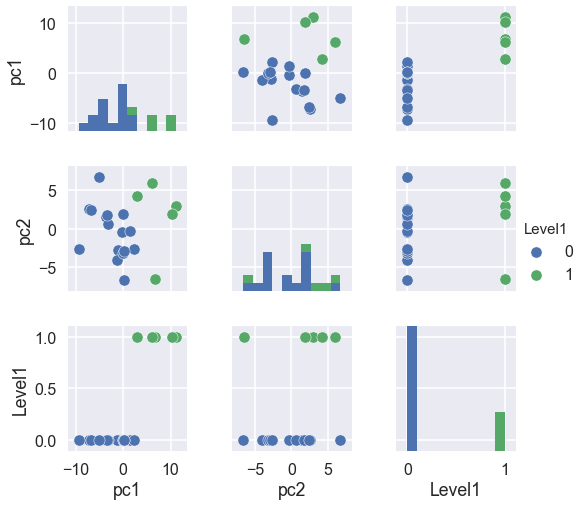

In [55]:
sns.pairplot(g0pca,hue="Level1")

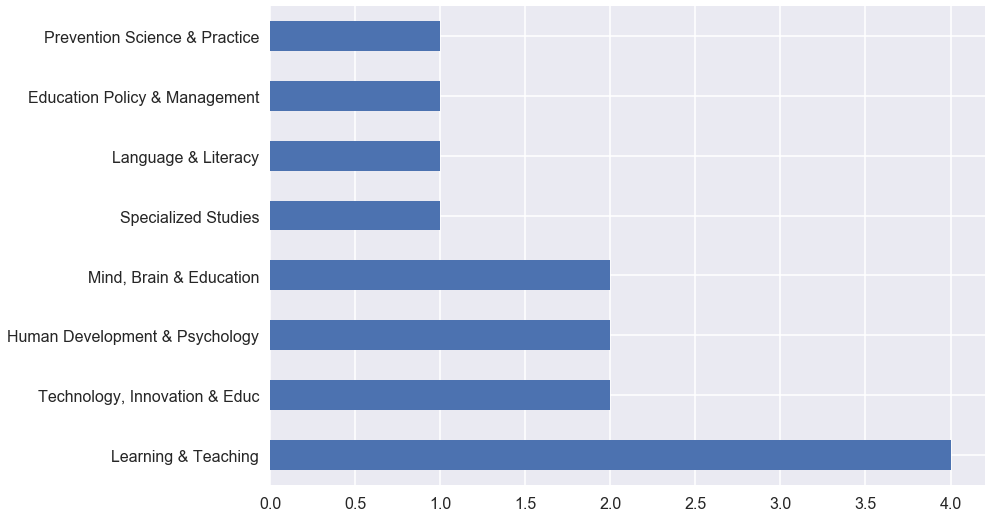

In [63]:
g0pca["Program"][g0pca.Level1 == 0].value_counts().plot(kind="barh")

In [57]:
g1_load, g1pca = do_pca(group_1,2,"Level1",text)

In [58]:
display_side_by_side(g1_load[["PC-1","text"]].sort_values(by="PC-1",ascending = False)[0:5],
                     g1_load[["PC-2","text"]].sort_values(by="PC-2",ascending = False)[0:5])

,PC-1,text
Q291,0.104118,(B) Talents are specific and limited. For exam...
Q296,0.094381,(B) Learners are ultimately responsible for th...
Q365,0.069073,(B) One-on-one coaching is more effective for ...
Q304,0.065077,(B) Being personally motivated to learn is mor...
Q267_4,0.059775,"(EE) There was a test, assignment, or other as..."
,PC-2,text
Q252_4,0.159968,(V) How to design learning experiences or curr...
Q252_8,0.130348,(V) How to evaluate teaching or educational pr...
Q382_25,0.128043,(F) Transfer of learning
Q252_13,0.109389,(V) The neuroscience of learning


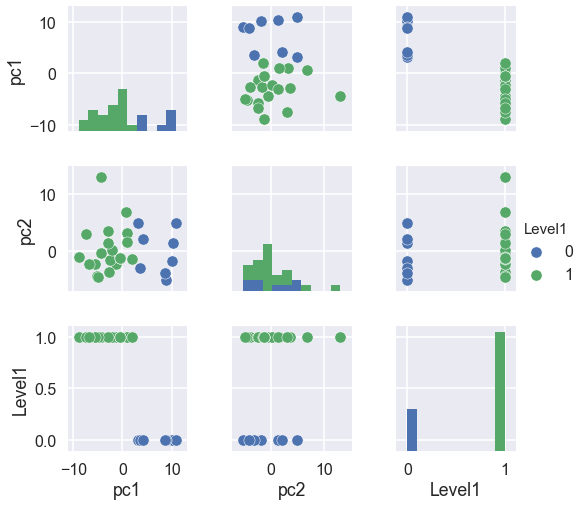

In [59]:
sns.pairplot(g1pca,hue="Level1")

In [60]:
g1pca["Program"][g1pca.Level1 == 1].describe()

count                      21
unique                      9
top       Learning & Teaching
freq                        4
Name: Program, dtype: object

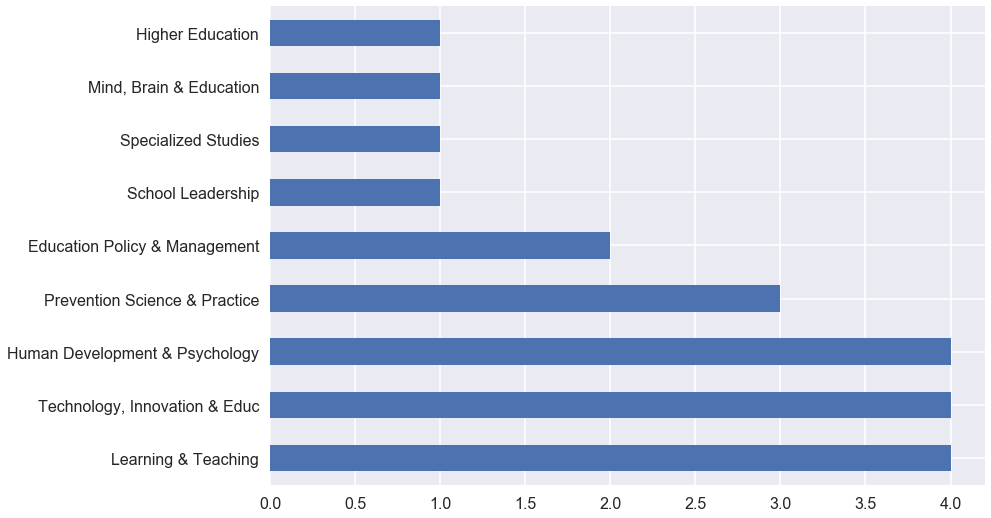

In [64]:
g1pca["Program"][g1pca.Level1 == 1].value_counts().plot(kind="barh")